# Introduction

Following on the heels of the policy gradient method, I'm moving over to the actor critic method.

In [243]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
import keras.optimizers 
from keras import backend as K
%matplotlib inline


class ActorCritic:
    
    def __init__(self,num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.actions = range(num_actions)
        self.learning_rate = 0.001
        
        #These will store the samples from which the agent will learn
        self.states = []
        self.action_samples = []
        self.rewards = []
        
        self.model = self._make_model()
        self._make_train_function()

        
    def _make_model(self):
        
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.num_states, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.num_actions, activation='softmax'))
        #model.compile(loss='mse',
        #              optimizer=Adam(lr=self.learning_rate))
        return model
    
    
    def _make_train_function(self):
        """
        Keras doesn't directly take a loss function (usually, input and labels)
        So have to make my own. Have to use the keras functional API for this
        """
        
        #Inputs -- call these 'holders', to remember they are templates
        state_holder = self.model.input
        action_onehot_holder = K.placeholder(name='action_onehot',shape=(None,self.num_actions))
        discounted_return_placeholder = K.placeholder(name='discounted_return',shape=(None,))
        
        #Loss
        prob_placeholder = self.model.output  #output has the same structure, so copy it
        action_prob = K.sum(prob_placeholder*action_onehot_placeholder,axis=1)
        log_action_prob = K.log(action_prob)
        loss_vec = -log_action_prob*discounted_return_placeholder
        loss = K.mean(loss_vec)
        
        #Doing the 'training' -- get the updates, this is the way keras works
        adam = optimizers.Adam()
        pars = self.model.trainable_weights
        updates = adam.get_updates(params=pars, loss=loss)
                
        #Defintion of function -- this takes the input and applies the 
        #updates; the syntax is weird!
        self.train = K.function(inputs=[state_holder,action_onehot_placeholder,discounted_return_placeholder],
                                outputs=[],updates = updates)

    
    def remember(self, state, action, reward):
        self.states.append(state)
        self.action_samples.append(action)
        self.rewards.append(reward)
        

    def act(self, state):
        """ Choose action according to softmax """
        
        probs =  self.model.predict(state)[0]
        action = np.random.choice(self.actions, p=probs)
        return action
    
        

    def learn(self):
        """
        Does the policy gradient step
        """
        
        S = np.array(self.states)    #2D array, (num_samples,state_dim)
        A = np.array(self.action_samples)   #1D array, (num_samples,)
        R = np.array(self.rewards)   #1D array, (num_samples,)
        
        #Prepare data
        A_onehot = to_categorical(A,agent.num_actions)
        discount_return = self.compute_discount_return(R)
        R_discounted = self.compute_discount_return(R)
        
        #Train
        self.train([S,A_onehot,R_discounted])
        
        #Erase memory
        self.states = []
        self.action_samples = []
        self.rewards = []
        
        
        
    def compute_discount_return(self,R):
        """
        Input:
        R = 1D array, list of rewards
        
        Output:
        discouted R, 1D 
        
        """
        R_discounted = np.zeros_like(R)
        running_total = 0
        for t in reversed(range(len(R_discounted))):
            running_total = running_total*gamma + R[t]
            R_discounted[t] = running_total
        return R_discounted
        

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

### Main

In [244]:
import gym


EPISODES = 1000

env = gym.make('CartPole-v1')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = PolicyAgent(num_states, num_actions)
# agent.load("./save/cartpole-dqn.h5")
done = False

scores = []

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, num_states])
    reward_sum = 0
    for time in range(500):
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])
        agent.remember(state[0], action, reward)
        state = next_state
        if done:
            break
    
    #Learn & print results
    agent.learn()
    scores.append(reward_sum)
    if e % 50 == 0:
        print '(episode, score) = ' + str((e,reward_sum))

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(episode, score) = (0, 4.0)
(episode, score) = (50, 3.0)
(episode, score) = (100, 16.0)
(episode, score) = (150, 120.0)
(episode, score) = (200, 142.0)
(episode, score) = (250, 283.0)
(episode, score) = (300, 354.0)
(episode, score) = (350, 112.0)
(episode, score) = (400, 107.0)
(episode, score) = (450, 158.0)
(episode, score) = (500, 102.0)
(episode, score) = (550, 144.0)
(episode, score) = (600, 255.0)
(episode, score) = (650, 313.0)
(episode, score) = (700, 489.0)
(episode, score) = (750, 489.0)
(episode, score) = (800, 183.0)
(episode, score) = (850, 489.0)
(episode, score) = (900, 489.0)
(episode, score) = (950, 489.0)


Sweet, that's pretty good learning -- right? I should do a baseline comparison.

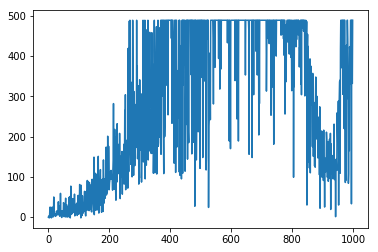

In [237]:
plt.plot(scores)

So pretty unstable. But this is just vanilla policy gradient stuff.

### Roughwork

From https://github.com/keon/policy-gradient/blob/master/pg.py

In [107]:
action = 0
action_onehot = to_categorical(action,agent.num_actions)

probs = agent.model.predict(state)
action_prob = K.sum(probs*action_onehot,axis=1)
log_action_prob = K.log(action_prob)

In [109]:
log_action_prob.eval()

array([-0.6775597], dtype=float32)

### Other environment

In [6]:
import gym


EPISODES = 1000

env = gym.make('MountainCar-v0')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n
agent = PolicyAgent(num_states, num_actions)
# agent.load("./save/cartpole-dqn.h5")
done = False

scores = []

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, [1, num_states])
    reward_sum = 0
    for time in range(500):
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward = reward if not done else -10
        reward_sum += reward
        next_state = np.reshape(next_state, [1, num_states])
        agent.remember(state[0], action, reward)
        state = next_state
        if done:
            break
    
    #Learn & print results
    agent.learn()
    scores.append(reward_sum)
    if e % 50 == 0:
        print '(episode, score) = ' + str((e,reward_sum))

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


NameError: name 'PolicyAgent' is not defined

In [5]:
env.action_space

Box(1,)